In [35]:
!pip install -q keras
!pip install h5py
!pip install pillow

## 2 Getting Started

I have slightly modified the code so that we can choose how often we want prints

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, print_every=10, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % print_every == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(print_every = 10):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, print_every = print_every)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0, print_every=10):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % print_every == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def visualize_multiple_prediction(x, y):
    nb_images = x.shape[0]
    fig, ax = plt.subplots(figsize=(5*2,int(nb_images/5)*3), nrows = int(nb_images/5), ncols = 5)
    I = x.reshape((-1,IMAGE_SIZE,IMAGE_SIZE))
    for i in range(nb_images):
      ax[int((i - i%5)/5), i%5].imshow(I[i], extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
      ax[int((i - i%5)/5), i%5].set_xlim([0,1])
      ax[int((i - i%5)/5), i%5].set_ylim([0,1])

      xy = y[i,:].reshape(3,2)
      tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
      ax[int((i - i%5)/5), i%5].add_patch(tri)

    plt.show()    

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3 Simple Classification


I convert the Ys taking values in $\{1,2,3\}$ to one-hot vectors for classification

In [85]:
from keras.utils import np_utils

[X_train, Y_train] = generate_dataset_classification(300, 20, print_every = 50)
#reshape y_train
y_train = np_utils.to_categorical(Y_train)

print('Shape of X: {}, shape of Y: {}, shape of y: {}'.format(X_train.shape,Y_train.shape,y_train.shape))

Creating data:
0
50
100
150
200
250
Shape of X: (300, 5184), shape of Y: (300,), shape of y: (300, 3)


A linear classifier is of the form $\sigma(w^TX) \approx Y$, where $w,X \in \mathbb{R}^n, Y \in \mathbb{R}$. Since we convert $Y$ from a scalar to a $\bar{Y}$ one-hot vector,  performing linear classification is the same as doing the operation $\sigma(\bar{W}^TX) \approx \bar{Y}$, where $\bar{W} \in \mathbb{R}^{n \times 3}$, and $\sigma$ is applied on each of the 3 outputs.

### Linear classifier, Stochastic Gradient Descent

I define the linear classifier as follows. The values for the SGD optimizer have been chosen heuristically, but the results were more or less equivalent when changing the hyperparameters.

In [113]:
from keras.models import Sequential
from keras.layers import Dense, Activation

##############NETWORK###################
#Layer 1
nb_neurons_1 = 3
model = Sequential([
Dense(nb_neurons_1, input_shape=(72*72,)), Activation('softmax')])

#Optimization
from keras.optimizers import SGD
sgd = SGD(lr=0.01,
decay=1e-6, momentum=0.9,
nesterov=True)
model_1layer.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

#Train
history = model_1layer.fit(X_train, y_train, validation_split=0.33, epochs=70, batch_size=10)

Train on 200 samples, validate on 100 samples
Epoch 1/70
200/200 [==============================] - 4s 21ms/step - loss: 0.2216 - acc: 0.3850 - val_loss: 0.2283 - val_acc: 0.2500
Epoch 2/70
200/200 [==============================] - 0s 669us/step - loss: 0.2214 - acc: 0.3850 - val_loss: 0.2268 - val_acc: 0.2500
Epoch 3/70
200/200 [==============================] - 0s 571us/step - loss: 0.2216 - acc: 0.3850 - val_loss: 0.2302 - val_acc: 0.2500
Epoch 4/70
200/200 [==============================] - 0s 587us/step - loss: 0.2214 - acc: 0.3850 - val_loss: 0.2270 - val_acc: 0.2500
Epoch 5/70
200/200 [==============================] - 0s 585us/step - loss: 0.2214 - acc: 0.3850 - val_loss: 0.2281 - val_acc: 0.2500
Epoch 6/70
200/200 [==============================] - 0s 594us/step - loss: 0.2212 - acc: 0.3850 - val_loss: 0.2275 - val_acc: 0.2500
Epoch 7/70
200/200 [==============================] - 0s 592us/step - loss: 0.2212 - acc: 0.3850 - val_loss: 0.2280 - val_acc: 0.2500
Epoch 8/70
200/20

We can visualize the convergence using the following code :

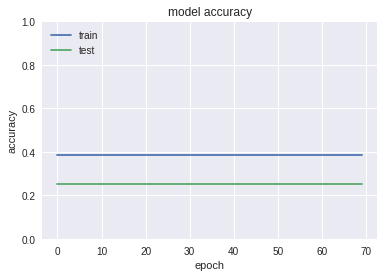

In [114]:
#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim((0,1))
plt.show()

We can also print the error rate on unseen data

In [115]:
#Test error
nb_test = 200
[X_test, Y_test] = generate_test_set_classification(print_every = 100)

#predict values and convert them to one-hot
y_predicted = model_1layer.predict(X_test)
Y_predicted = [np.argmax(y_predicted[i,:]) for i in range(nb_test)]
y_predicted = np_utils.to_categorical(Y_predicted)

Error = Y_test - y_predicted
error_rate = np.mean([np.linalg.norm(Error[i,:],1) for i in range(nb_test)])/3.
  
print('Error rate is {}'.format(np.round(error_rate,3)))

Creating data:
0
100
200
Error rate is 1.003999948501587


#### Conclusions: the optimizer seems to get stuck in the local minimum it was in and doesn't manage to move, which explains the constant error throughout the epochs.




### Linear classifier, Adam optimizer

In [117]:
from keras.models import Sequential
from keras.layers import Dense, Activation

#Just 1 layer
nb_neurons_1 = 3
model = Sequential([
Dense(nb_neurons_1, input_shape=(72*72,)), Activation('softmax')])

#Optimizer choice
#Optimization
from keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

#Train
history = model.fit(X_train, y_train, validation_split=0.33, epochs=70, batch_size=10)

Train on 200 samples, validate on 100 samples
Epoch 1/70
200/200 [==============================] - 4s 21ms/step - loss: 0.2069 - acc: 0.4550 - val_loss: 0.1871 - val_acc: 0.5200
Epoch 2/70
200/200 [==============================] - 0s 623us/step - loss: 0.1588 - acc: 0.6750 - val_loss: 0.1645 - val_acc: 0.5900
Epoch 3/70
200/200 [==============================] - 0s 609us/step - loss: 0.1409 - acc: 0.7400 - val_loss: 0.1508 - val_acc: 0.7500
Epoch 4/70
200/200 [==============================] - 0s 595us/step - loss: 0.1223 - acc: 0.7400 - val_loss: 0.1476 - val_acc: 0.6200
Epoch 5/70
200/200 [==============================] - 0s 668us/step - loss: 0.1139 - acc: 0.8000 - val_loss: 0.1294 - val_acc: 0.7800
Epoch 6/70
200/200 [==============================] - 0s 633us/step - loss: 0.1008 - acc: 0.8150 - val_loss: 0.1236 - val_acc: 0.7600
Epoch 7/70
200/200 [==============================] - 0s 636us/step - loss: 0.0936 - acc: 0.8300 - val_loss: 0.1104 - val_acc: 0.7900
Epoch 8/70
200/20

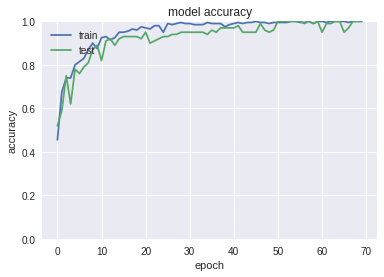

In [118]:
#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
#predict values and convert them to one-hot
y_predicted = model.predict(X_test)
Y_predicted = [np.argmax(y_predicted[i,:]) for i in range(nb_test)]
y_predicted = np_utils.to_categorical(Y_predicted)

Error = Y_test - y_predicted
error_rate = np.mean([np.linalg.norm(Error[i,:],1) for i in range(nb_test)])/3.
  
print('Error rate is {}'.format(np.round(error_rate,3)))

Error rate is 0.0


#### The difference using state of the art Adam optimizer is huge, the convergence is very quick and the result is as good as we could hope for a linear classifier on this problem.

## 4 - Visualization of the Solution

model.get_weights() outputs $\hat{W}$.Each of the 3 columns therefore correspond to the weights of one of the 3 shapes, and can be reshaped as images easily.

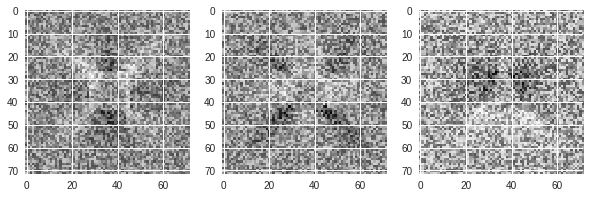

In [120]:
Weights_layer_1 = model.get_weights()[0]

plt.figure(figsize = (10,20))

plt.subplot(131)
im = Weights_layer_1[:,0]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE))

plt.subplot(132)
im = Weights_layer_1[:,1]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE))

plt.subplot(133)
im = Weights_layer_1[:,2]
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE))

plt.show()

#### We can see that the weights are mostly made of noise, except in the areas that differentiate the 3 shapes. 
#### Indeed, we can see for example that the second weight vector, corresponding to the circle shape, assigns bigger weights in the center, except for diagonal lines crossing the center where the weights are close to 0 (because circles don't have edges), while the first weight vector corresponding to the square assigns values closer to 1 on those lines (because squares have edges).

## 5 A more Difficult Classification Problem

###Linear classifier

Let's try training the same classifier as above on a set of shapes that can now move around.

In [121]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation

[X_train, Y_train] = generate_dataset_classification(300, 20, 50, True)
#reshape y_train
y_train = np_utils.to_categorical(Y_train)

#Just 1 layer
nb_neurons_1 = 3
model = Sequential([
Dense(nb_neurons_1, input_shape=(5184,)),
Activation('softmax')])

#Optimizer choice
#Optimization
from keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

#Train
history = model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=10)

Creating data:
0
50
100
150
200
250
Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 4s 22ms/step - loss: 0.2345 - acc: 0.4050 - val_loss: 0.2580 - val_acc: 0.3700
Epoch 2/100
200/200 [==============================] - 0s 620us/step - loss: 0.2375 - acc: 0.4050 - val_loss: 0.2194 - val_acc: 0.4400
Epoch 3/100
200/200 [==============================] - 0s 628us/step - loss: 0.2190 - acc: 0.4000 - val_loss: 0.2120 - val_acc: 0.4500
Epoch 4/100
200/200 [==============================] - 0s 640us/step - loss: 0.2151 - acc: 0.4150 - val_loss: 0.2148 - val_acc: 0.3900
Epoch 5/100
200/200 [==============================] - 0s 627us/step - loss: 0.2119 - acc: 0.4050 - val_loss: 0.2122 - val_acc: 0.3900
Epoch 6/100
200/200 [==============================] - 0s 657us/step - loss: 0.2069 - acc: 0.4500 - val_loss: 0.2121 - val_acc: 0.3700
Epoch 7/100
200/200 [==============================] - 0s 673us/step - loss: 0.1978 - acc: 0.4800 - val_loss:

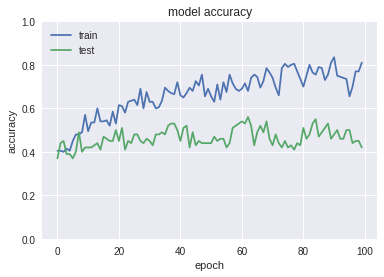

Error rate is 0.449


In [125]:
#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#predict values and convert them to one-hot
y_predicted = model.predict(X_test)
Y_predicted = [np.argmax(y_predicted[i,:]) for i in range(nb_test)]
y_predicted = np_utils.to_categorical(Y_predicted)

Error = Y_test - y_predicted
error_rate = np.mean([np.linalg.norm(Error[i,:],1) for i in range(nb_test)])/3.
  
print('Error rate is {}'.format(np.round(error_rate,3)))

#### We can see that the results are a lot loss impressive than earlier, and in fact in this case the network has overlearned the input data.

#### This is because the structure of the network isn't adapted for this problem: linear classifiers don't take into account the spacial coherence of the input, which is why the network performed well on the previous problem. Indeed, it simply learned the areas where certain shapes were more likely to be in, without looking at the structure of the image.

#### To correctly classify this data, we could use a deeper neural network and hope that the network would manage to "learn" the relationship between different parts of the image, but this network would probably be very slow to train and have a lot of bad local minima.

#### A better approach is to visualise the input as an image and use convolutions between each layer.

###Convolutional Network

In [0]:
#Reshape Xs as images
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

#### This structure has been chosen through trial and error and doesn't rely on a lot of theory. I used some batch normalization for better convergence, dropout to avoid overfitting and I used reLu and tried not to make the network too dense to avoid vanishing gradients.

#### I also kept the same number of training samples to emphasize the performance of the ConvNet.

In [127]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(72, 72, 1)) )
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())          
model.add(Dropout(0.15))
          
model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(72, 72, 1)) )
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
          
model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(72, 72, 1)) )
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(32, (3, 3), activation='relu',
                 input_shape=(72, 72, 1)) )
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
          
model.add(Dense(3, activation='softmax'))

#Optimizer choice
from keras.optimizers import Adam
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

#Train
history = model.fit(X_train, y_train, validation_split=0.33, epochs=250, batch_size=10)

(None, 35, 35, 32)
(None, 16, 16, 32)
(None, 7, 7, 32)
(None, 2, 2, 32)
(None, 128)
Train on 200 samples, validate on 100 samples
Epoch 1/250
200/200 [==============================] - 5s 27ms/step - loss: 2.0137 - acc: 0.2700 - val_loss: 1.1425 - val_acc: 0.3100
Epoch 2/250
200/200 [==============================] - 0s 2ms/step - loss: 1.4803 - acc: 0.3400 - val_loss: 1.1244 - val_acc: 0.2700
Epoch 3/250
200/200 [==============================] - 0s 2ms/step - loss: 1.3576 - acc: 0.3000 - val_loss: 1.1153 - val_acc: 0.2200
Epoch 4/250
200/200 [==============================] - 0s 2ms/step - loss: 1.2882 - acc: 0.3100 - val_loss: 1.1115 - val_acc: 0.3600
Epoch 5/250
200/200 [==============================] - 0s 2ms/step - loss: 1.2379 - acc: 0.3450 - val_loss: 1.1096 - val_acc: 0.3600
Epoch 6/250
200/200 [==============================] - 0s 2ms/step - loss: 1.2141 - acc: 0.3100 - val_loss: 1.1078 - val_acc: 0.4000
Epoch 7/250
200/200 [==============================] - 0s 2ms/step - lo

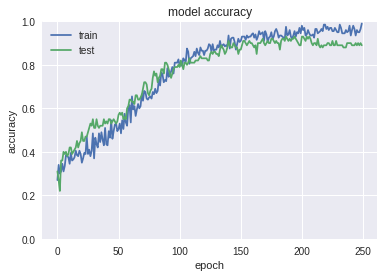

Error rate is 0.093


In [129]:
#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#predict values and convert them to one-hot
y_predicted = model.predict(X_test)
Y_predicted = [np.argmax(y_predicted[i,:]) for i in range(nb_test)]
y_predicted = np_utils.to_categorical(Y_predicted)

Error = Y_test - y_predicted
error_rate = np.mean([np.linalg.norm(Error[i,:],1) for i in range(nb_test)])/3.
  
print('Error rate is {}'.format(np.round(error_rate,3)))

#### The result is quite good, even though there is a little overlearning at the end.

## 6  A Regression Problem

In [4]:
[X_train, Y_train] = generate_dataset_regression(2000, 20, 500)
[X_test, Y_test] = generate_test_set_regression()
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)

Creating data:
0
500
1000
1500
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


#### Since the coordinates of the edges aren't given in any particular order, it would be wise to reorder them in some was that the network could learn so that the loss makes sense.

#### I have tried 2 different approaches which have yielded equivalent results:

In [0]:
def normalize(Y_train):  #Orders the edges following their y-axis coordinate
  
  x,y = Y_train.shape
  Y = np.zeros((x,y-2))
  for i in range(len(Y_train)):
    
    
    Y_i = Y_train[i].copy()
    sort_even = np.argsort(Y_i[::2])*2 #extrait les valeurs paires
    Y_train[i][::2] = Y_i[sort_even]
    Y_train[i][1::2] = Y_i[sort_even + 1]
    Y[i] = Y_train[i][2:]
    
  return Y_train

In [0]:
def normal_angle(Y_train):   #Orders the edges following the angles they make with the x-axis
  
  length,_ = Y_train.shape
  Y_normalised = Y_train.copy()
  theta = np.zeros(3)
  for i in range(length):
    
    theta[0] = np.arctan(Y_train[i][0]/Y_train[i][1])
    theta[1] = np.arctan(Y_train[i][2]/Y_train[i][3])
    theta[2] = np.arctan(Y_train[i][4]/Y_train[i][5])
    sort = np.argsort(theta)*2
    Y_normalised[i] = np.array([Y_train[i][s:s+2] for s in sort]).flatten()
    
  return Y_normalised

In [0]:
y_train = normalize(Y_train)

Train on 1700 samples, validate on 300 samples
Epoch 1/150
1700/1700 [==============================] - 4s 2ms/step - loss: 0.0740 - acc: 0.4812 - val_loss: 0.0501 - val_acc: 0.6167
Epoch 2/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0344 - acc: 0.6241 - val_loss: 0.0297 - val_acc: 0.6967
Epoch 3/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0244 - acc: 0.6965 - val_loss: 0.0194 - val_acc: 0.7867
Epoch 4/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0211 - acc: 0.7082 - val_loss: 0.0177 - val_acc: 0.7967
Epoch 5/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0184 - acc: 0.7359 - val_loss: 0.0132 - val_acc: 0.8300
Epoch 6/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0165 - acc: 0.7388 - val_loss: 0.0119 - val_acc: 0.8233
Epoch 7/150
1700/1700 [==============================] - 2s 1ms/step - loss: 0.0154 - acc: 0.7494 - val_loss: 0.0137 - val_acc: 0.8167
Epoch 8/

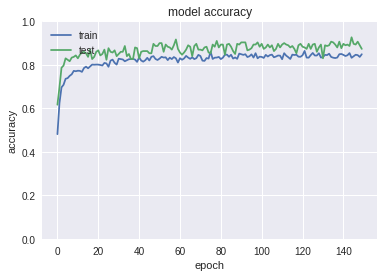

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Concatenate

model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu',
                 input_shape=(72, 72, 1)) )
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())          
model.add(Dropout(0.15))
          
model.add(Conv2D(64, (8, 8), activation='relu') )
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization()) 
model.add(Dropout(0.15))

model.add(Conv2D(64, (5, 5), activation='relu') )
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization()) 
model.add(Dropout(0.15))

#flatten
model.add(Flatten())
model.add(Dropout(0.4))

#layer1
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(6, activation='relu'))

#Optimizer choice
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0000001, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

#Train
history = model.fit(X_train, y_train, validation_split=0.15, epochs=150, batch_size=16)
model.save_weights('my_model_weights.h5')

#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

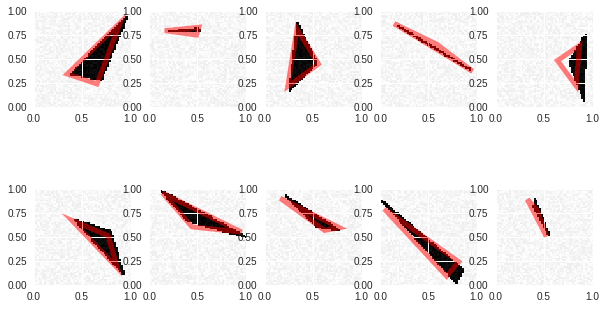

In [23]:
y_pred = model.predict(X_test[:10])
visualize_multiple_prediction(X_test[:10], y_pred[:10])
plt.show()

#### As we can see, even if the accuracy is around 0.9, the visual result is still very good.

## 7 

#### Modification of the generate_a_* function

In [0]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)
  
def generate_dataset_classification_noisy(nb_samples, noise=0.0, print_every=10, free_location=False):
  # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % print_every == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255.
    return [X.reshape(-1,72,72,1), Y.reshape(-1,72,72,1)]

### Denoizing

In [200]:
import matplotlib.pyplot as plt
import numpy as np
[X_train, Y_train] = generate_dataset_classification_noisy(1000, noise=50.0, print_every=100, free_location=False)
[X_test, Y_test] = generate_dataset_classification_noisy(300, noise=50.0, print_every=100, free_location=False)

Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


#### We now wish to denoise images such as the one below:

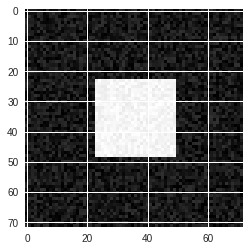

In [201]:
plt.imshow(X_test[0].reshape(72,72))

#### I have decided to use 1 hourglass with residuals for my network, as inspired by the U-Net architecture. In order to achieve a quicker convergence, and to avoid bad local minima (such as an all-white image that can be induced with l1 or l2 loss).

#### I will start by using binary crossentropy loss to make the loss function more convex, and therefore garantee to get close to the desired global minimum. I will also use activity_regularizer to regularize the output.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Train on 850 samples, validate on 150 samples
Epoch 1/35
850/850 [==============================] - 16s 19ms/step - loss: 12.1823 - acc: 0.2650 - val_loss: 2.0585 - val_acc: 0.2210
Epoch 2/35
850/850 [==============================] - 7s 8ms/step - loss: 2.0043 - acc: 0.2219 - val_loss: 1.8908 - val_acc: 0.2210
Epoch 3/35
850/850 [==============================] - 7s 8ms/step - loss: 1.8529 - acc: 0.2219 - val_loss: 1.7505 - val_acc: 0.2210
Epoch 4/35
850/850 [==============================] - 7s 8ms/step - loss: 1.7188 - acc: 0.2219 - val_loss: 1.6269 - val_acc: 0.2210
Epoch 5/35
850/850 [==============================] - 7s 8ms/step - loss: 1.6034 - acc: 0.2219 - val_loss: 1.5307 - val_acc: 0.2210
Epoch 6/35
850/850 [==============================] - 7s 8ms/step - loss: 1.5138 - acc: 0.2219 - val_loss: 1.4485 - val_acc: 0.2210
Epoch 7/35
850/850 [==============================] - 7s 8ms/step - loss: 1.4341 - acc: 0.2219 - val_loss: 1.3633 - val_acc: 0.2210
Epoch 8/35
850/850 [=======

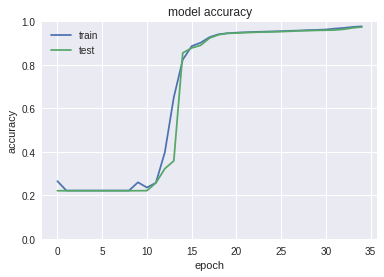

In [208]:
from keras.models import Model
from keras.layers import merge, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, UpSampling2D, Conv2DTranspose
from keras.layers import Add
from keras import regularizers

inputs = Input((72, 72, 1))

##########HOURGLASS################
conv_size = 4

#downsampling
conv_down1 = Conv2D(64, conv_size, activation = 'relu', padding='same')(inputs)
pool_down1 = MaxPooling2D(pool_size=(2, 2))(conv_down1)

conv_down2 = Conv2D(128, conv_size*2, activation = 'relu', padding='same')(pool_down1)
pool_down2 = MaxPooling2D(pool_size=(2, 2))(conv_down2)

conv_down3 = Conv2D(256, conv_size*4, activation = 'relu', padding='same')(pool_down2)
pool_down3 = MaxPooling2D(pool_size=(2, 2))(conv_down3)
conv_middle = Conv2D(256, conv_size, activation = 'relu', padding='same',activity_regularizer=regularizers.l1(0.00001))(pool_down3)

#upsampling
up_sample1 = UpSampling2D(size = (2,2))(conv_middle)
up_sample1 = Add()([up_sample1,conv_down3])
conv_up1 = Conv2D(128, conv_size, activation = 'relu', padding='same',activity_regularizer=regularizers.l1(0.00001))(up_sample1)

up_sample2 = UpSampling2D(size = (2,2))(conv_up1)
up_sample2 = Add()([up_sample2,conv_down2])
conv_up2 = Conv2D(64, conv_size, activation = 'relu', padding='same',activity_regularizer=regularizers.l1(0.00001))(up_sample2)

up_sample3 = UpSampling2D(size = (2,2))(conv_up2)
up_sample3 = Add()([up_sample3,conv_down1])
conv_up3 = Conv2D(64, conv_size, activation = 'relu', padding='same',activity_regularizer=regularizers.l1(0.00001))(up_sample3)

#Output
out = Conv2D(1, 2, activation = 'tanh', padding='same')(conv_up3)
model = Model(input = [inputs], output = [out])

#Optimizer
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer = adam,
loss = 'binary_crossentropy', metrics=['accuracy'])

#Train
history = model.fit(X_train.reshape(-1,72,72,1), Y_train.reshape(-1,72,72,1), validation_split=0.15, epochs=35, batch_size=40)

#plot error
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

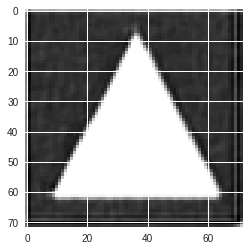

In [209]:
plt.imshow(model.predict(X_test)[2].reshape(72,72))

#### As we can see, the result is good but the ouput has dark gray patches where we would like it to be black, because the loss function didn't impose this.

#### To achieve the desired result, we can fine-tune the network by freezing all layers, adding another convolutional layer and imposing a L1 or L2 loss

In [210]:
for layer in model.layers:
    layer.trainable = False
    
out = Conv2D(1, 2, activation = 'tanh', padding='same')(out)

model = Model(input = [inputs], output = [out])
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer = 'adam',
loss = 'mean_squared_error', metrics=['accuracy'])

#Train
history = model.fit(X_train.reshape(-1,72,72,1), Y_train.reshape(-1,72,72,1), validation_split=0.15, epochs=5, batch_size=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  


Train on 850 samples, validate on 150 samples
Epoch 1/5
850/850 [==============================] - 14s 17ms/step - loss: 0.4919 - acc: 0.2219 - val_loss: 0.3775 - val_acc: 0.2212
Epoch 2/5
850/850 [==============================] - 5s 6ms/step - loss: 0.3173 - acc: 0.6361 - val_loss: 0.2723 - val_acc: 0.9605
Epoch 3/5
850/850 [==============================] - 5s 6ms/step - loss: 0.2481 - acc: 0.9662 - val_loss: 0.2293 - val_acc: 0.9684
Epoch 4/5
850/850 [==============================] - 5s 6ms/step - loss: 0.2185 - acc: 0.9688 - val_loss: 0.2098 - val_acc: 0.9679
Epoch 5/5
850/850 [==============================] - 5s 6ms/step - loss: 0.2044 - acc: 0.9682 - val_loss: 0.1999 - val_acc: 0.9678


####As we can see, the result is near-perfect, modulo some normalization

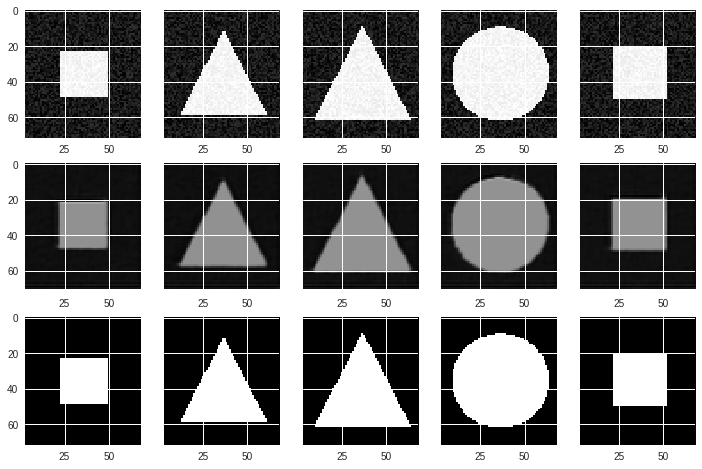

In [211]:
f, ax = plt.subplots(3, 5, sharey=True, figsize = (12,8))

for i in range(5):
  ax[0,i].imshow(X_test[i].reshape(72,72))
  ax[1,i].imshow(model.predict(X_test)[i].reshape(72,72))
  ax[2,i].imshow(Y_test[i].reshape(72,72))
plt.show()